# Predicting Bankruptcy in Taiwan Using Decision Tree Model

In [1]:
import gzip
import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import VimeoVideo
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier


# Prepare Data

## Import

Let us reload our wrangle function from the previous notebook.

In [2]:
# load wrangle function
def wrangle(filename):
    # open compressed file,load into dict
    with gzip.open(filename,"r") as f:
        data = json.load(f)
        
    # turn dict into dataframe
    df = pd.DataFrame().from_dict(data["observations"]).set_index("id")
    
    return df

In [3]:
df = wrangle("data/taiwan-bankruptcy-data.json.gz")
print("df shape:", df.shape)
df.head()

df shape: (6137, 96)


,bankrupt,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
id,,,,,,,,,,,,,,,,,,,,,
1,True,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
2,True,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
3,True,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
4,True,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
5,True,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


## Explore

In [4]:
# Inspect a DataFrame using the info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6137 entries, 1 to 6819
Data columns (total 96 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   bankrupt  6137 non-null   bool   
 1   feat_1    6137 non-null   float64
 2   feat_2    6137 non-null   float64
 3   feat_3    6137 non-null   float64
 4   feat_4    6137 non-null   float64
 5   feat_5    6137 non-null   float64
 6   feat_6    6137 non-null   float64
 7   feat_7    6137 non-null   float64
 8   feat_8    6137 non-null   float64
 9   feat_9    6137 non-null   float64
 10  feat_10   6137 non-null   float64
 11  feat_11   6137 non-null   float64
 12  feat_12   6137 non-null   float64
 13  feat_13   6137 non-null   float64
 14  feat_14   6137 non-null   float64
 15  feat_15   6137 non-null   float64
 16  feat_16   6137 non-null   float64
 17  feat_17   6137 non-null   float64
 18  feat_18   6137 non-null   float64
 19  feat_19   6137 non-null   float64
 20  feat_20   6137 non-null   floa

That's solid information. We know all our features are numerical and that we have no missing data. But, as always, it's a good idea to do some visualizations to see if there are any interesting trends or ideas we should keep in mind while we work. First, let's take a look at how many firms are bankrupt, and how many are not.

In [5]:
df["bankrupt"].value_counts(normalize=True)

False    0.96904
True     0.03096
Name: bankrupt, dtype: float64

Next lets create a visual representation of this .


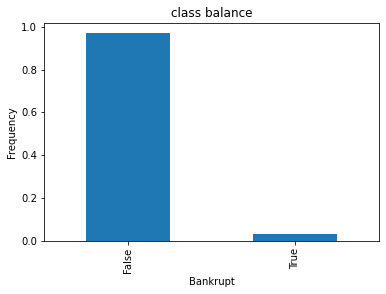

In [6]:
# Plot class balance
df["bankrupt"].value_counts(normalize=True).plot(
    kind = "bar",
    xlabel = "Bankrupt",
    ylabel = "Frequency",
    title ="class balance"
);

From the bar chart above we can see that about 97% of the companies are not bankrupt while, 3% of the data a experiencing bankruptcy.

In the last notebook, we saw that there were 96 features of each company, each of which had some kind of numerical value. It might be useful to understand where the values for one of these features cluster, so let's make a boxplot to see how the values in some of these features are distributed.Let us randomly consider "feat_86" and "feat_10" 

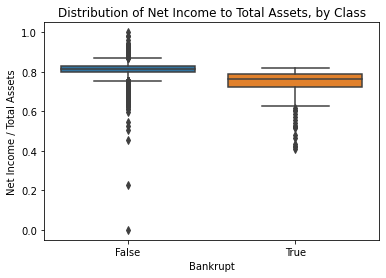

In [7]:
#Use seaborn to create a boxplot that shows the distributions of the "feat_86" column for both groups in the "bankrupt" column
# Create boxplot
sns.boxplot(x="bankrupt",y="feat_86",data=df)
plt.xlabel("Bankrupt")
plt.ylabel("Net Income / Total Assets")
plt.title("Distribution of Net Income to Total Assets, by Class");

In [8]:
# Summary statistics for `feat_86`
df['feat_86'].describe().apply("{0:,.0f}".format)

count    6,137
mean         1
std          0
min          0
25%          1
50%          1
75%          1
max          1
Name: feat_86, dtype: object

Note that the median is around 1, but the mean is also 1. That suggests that this feature is symmetric. Let's make a histogram to see what the distribution actually looks like.

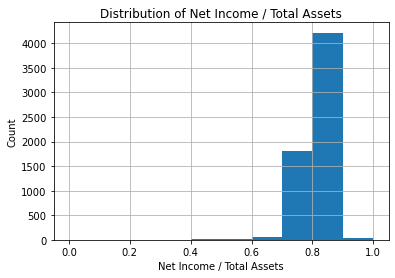

In [9]:
# Plot histogram of `feat_86`
df["feat_86"].hist()
plt.xlabel("Net Income / Total Assets")
plt.ylabel("Count"),
plt.title("Distribution of Net Income / Total Assets");

Next for "feat_10"

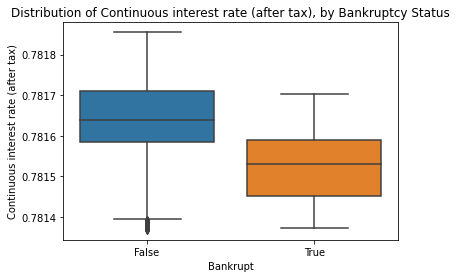

In [10]:
#Use seaborn to create a boxplot that shows the distributions of the "feat_10" column for both groups in the "bankrupt" column
# Create boxplot
# Create clipped boxplot
q1,q9 = df["feat_10"].quantile([0.1,0.9])
mask = df["feat_10"].between(q1,q9)
sns.boxplot(x="bankrupt",y="feat_10",data=df[mask])
plt.xlabel("Bankrupt")
plt.ylabel("Continuous interest rate (after tax)")
plt.title("Distribution of Continuous interest rate (after tax), by Bankruptcy Status");

In [11]:
# Summary statistics for `feat_10`
df['feat_10'].describe().apply("{0:,.0f}".format)

count    6,137
mean         1
std          0
min          0
25%          1
50%          1
75%          1
max          1
Name: feat_10, dtype: object

Just like "feat_86" Note that the median is around 1, but the mean is also 1. That suggests that this feature is symmetric. Let's make a histogram to see what the distribution actually looks like.

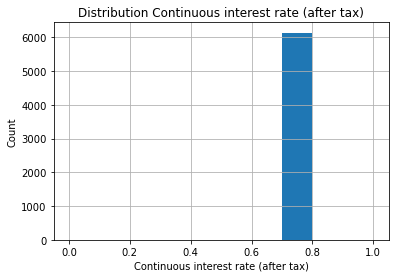

In [12]:
# Plot histogram of `feat_10`
df["feat_10"].hist()
plt.xlabel("Continuous interest rate (after tax)")
plt.ylabel("Count"),
plt.title("Distribution Continuous interest rate (after tax)");

Another important consideration for model selection is whether there are any issues with multicollinearity in our model. Let's check.

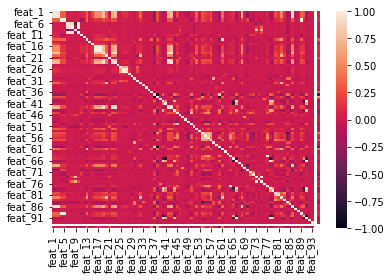

In [13]:
# Plot a correlation heatmap of features in df
corr = df.drop(columns="bankrupt").corr()
sns.heatmap(corr);

Some keypoints from this EDA. First, our data is imbalanced. This is something we need to address in our data preparation. Second, many of our features have  no missing values. And since the features are symmetric,  imputation strategy is not required. Finally, we have autocorrelation issues, which means that we should steer clear of linear models, and try a tree-based model instead.

## Split

Next I'll Create your feature matrix X and target vector y. Your target is "bankrupt"

In [14]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6137, 95)
y shape: (6137,)


In order to make sure that our model can generalize, we need to put aside a test set that we'll use to evaluate our model once it's trained.

Next I'll Divide your data (X and y) into training and test sets using a randomized train-test split. Your validation set should be 20% of your total data.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)    

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4909, 95)
y_train shape: (4909,)
X_test shape: (1228, 95)
y_test shape: (1228,)


## Resample

Now that we've split our data into training and validation sets, we can address the class imbalance we saw during our EDA. One strategy is to resample the training data.

### Under Sampling

When data is imbalanced in different classes, one way we can balance it is reducing the number of observations in the majority class. This is called under-sampling.

In [16]:
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
print(X_train_under.shape)
X_train_under.head()

(306, 95)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
0,0.482572,0.550262,0.535789,0.613918,0.613918,0.999156,0.797578,0.809489,0.303462,0.781796,...,0.805946,0.011432,0.621954,0.613916,0.840860,0.279876,0.026930,0.565745,1,0.028865
1,0.501146,0.561710,0.555758,0.605017,0.605017,0.999055,0.797478,0.809394,0.303498,0.781661,...,0.810046,0.002660,0.623756,0.605018,0.841375,0.281707,0.027014,0.566035,1,0.024010
2,0.507922,0.561655,0.556240,0.618155,0.618155,0.999086,0.797477,0.809390,0.303432,0.781651,...,0.814528,0.004703,0.623971,0.618154,0.841038,0.275810,0.026805,0.565224,1,0.096008
3,0.542242,0.598397,0.585310,0.607309,0.607432,0.999069,0.797540,0.809429,0.303579,0.781697,...,0.829716,0.002456,0.623817,0.607311,0.843257,0.281792,0.026806,0.565229,1,0.023845
4,0.581729,0.631215,0.620429,0.617327,0.617327,0.999250,0.797721,0.809562,0.303517,0.781833,...,0.851936,0.001350,0.624851,0.617322,0.843088,0.275912,0.026791,0.565159,1,0.088917


### Over Sampling

Over-sampling is the opposite of under-sampling. Instead of reducing the majority class, over-sampling increases the number of observations in the minority class by randomly making copies of the existing observations.

In [17]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
X_train_over.head()

(9512, 95)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
0,0.535855,0.599160,0.594411,0.627099,0.627099,0.999220,0.797686,0.809591,0.303518,0.781865,...,0.834091,0.022025,0.624364,0.627101,0.841977,0.275384,0.026791,0.565158,1,0.147943
1,0.554136,0.612734,0.595000,0.607388,0.607388,0.999120,0.797614,0.809483,0.303600,0.781754,...,0.840293,0.002407,0.624548,0.607385,0.842645,0.276532,0.026791,0.565158,1,0.062544
2,0.549554,0.603467,0.599122,0.620166,0.620166,0.999119,0.797569,0.809470,0.303524,0.781740,...,0.840403,0.000840,0.624010,0.620163,0.842873,0.277249,0.026800,0.565200,1,0.047929
3,0.543801,0.603249,0.606992,0.622515,0.622515,0.999259,0.797728,0.809649,0.303510,0.781930,...,0.831514,0.006176,0.626775,0.622513,0.842989,0.280013,0.026839,0.565375,1,0.028386
4,0.498659,0.562364,0.546978,0.603670,0.603670,0.998904,0.797584,0.809459,0.304000,0.781713,...,0.811988,0.004256,0.623674,0.603669,0.841105,0.277628,0.026897,0.565618,1,0.043080


# Build Model

## Baseline

A natural choice for a metric for classification is accuracy. Accuracy is equal to the number of observations you correctly classified over all observations

In [18]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9688


Note here that, because our classes are imbalanced, the baseline accuracy is very high. We should keep this in mind because, even if our trained model gets a high validation accuracy score, that doesn't mean it's actually good.

## Iterate

Now that we have a baseline, let's build a model to see if we can beat it.

Next I'll Create three identical models: model_reg, model_under and model_over.followed by a DecisionTreeClassifier.I'll  Train model_reg using the unaltered training data. For model_under, use the undersampled data. For model_over, use the oversampled data.

In [19]:
# Fit on `X_train`, `y_train`
model_reg = make_pipeline(
 DecisionTreeClassifier(random_state=42)
)
model_reg.fit(X_train, y_train)

# Fit on `X_train_under`, `y_train_under`
model_under =  make_pipeline(
 DecisionTreeClassifier(random_state=42)
)
model_under.fit(X_train_under, y_train_under)

# Fit on `X_train_over`, `y_train_over`
model_over =  make_pipeline(
 DecisionTreeClassifier(random_state=42)
)
model_over.fit(X_train_over, y_train_over)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

Next I'll Calculate training and test accuracy for your three models.

In [20]:
for m in [model_reg, model_under, model_over]:
    acc_train = m.score(X_train,y_train)
    acc_test = m.score(X_test,y_test)

    print("Training Accuracy:", round(acc_train, 4))
    print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9593
Training Accuracy: 0.7721
Test Accuracy: 0.7606
Training Accuracy: 1.0
Test Accuracy: 0.9642


we can see that the model_over gave the best training and test accuracy.

As we mentioned earlier, "good" accuracy scores don't tell us much about the model's performance when dealing with imbalanced data. So instead of looking at what the model got right or wrong, let's see how its predictions differ for the two classes in the dataset.

Plot a confusion matrix that shows how your best model performs on your validation set.

A confusion matrix is a table summarizing the performance of the model by enumerating true and false positives and the true and false negatives.




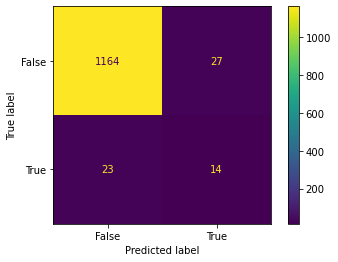

In [21]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model_reg,X_test,y_test);

Now let's Determine the depth of the decision tree in model_over, since its our best performing model.

In [22]:
depth = model_over["decisiontreeclassifier"].get_depth()
print(depth)

46


# Communicate

Now that we have a reasonable model, let's graph the importance of each feature.

Now let us Create a horizontal bar chart with the 15 most important features for model_over.

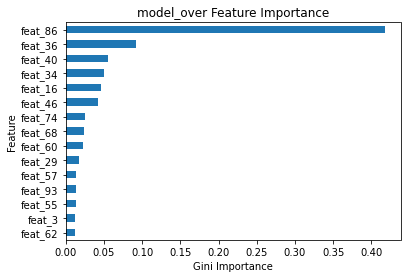

In [23]:
# Get importances
importances = model_over["decisiontreeclassifier"].feature_importances_

# Put importances into a Series
feat_imp = pd.Series(importances,index=X_train_over.columns).sort_values()

# Plot series
feat_imp.tail(15).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("model_over Feature Importance");

we can see from the visualization that feat_86 is our most important feature followed by feat_36 aand feat_40 respectively.

Finally Using a context manager, I'll save your best-performing model to a a file named "model-Decision-Tree.pkl"

In [27]:
# Save your model as `"model-Decision-Tree.pkl"`
with open("model-Decision-Tree.pkl","wb") as f:
    pickle.dump(model_over,f)